# Fitting of 2D PES

In this case, we consider PES written by
$$
V(x,y) = 4x^2 + 3y^2 + 2xy
$$

In [1]:
import platform
import sys

import pompon

print(sys.version)
print(f"pompon version = {pompon.__version__}")
print(platform.platform())

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pompon version = 0.0.9
macOS-14.4.1-arm64-arm-64bit


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from pompon.layers.tensor import TwodotCore
from pompon.utils import train_test_split

In [3]:
def ellipse_pes(
    x: np.ndarray | float, y: np.ndarray | float
) -> np.ndarray | float:
    return 4.0 * x**2 + 3.0 * y**2 + 2.0 * x * y

In [4]:
def plot_ellipse():
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = ellipse_pes(X.flatten(), Y.flatten()).reshape(X.shape)
    plt.contourf(X, Y, Z, 50, cmap="RdGy", vmax=9, vmin=0)
    plt.colorbar()
    plt.show()

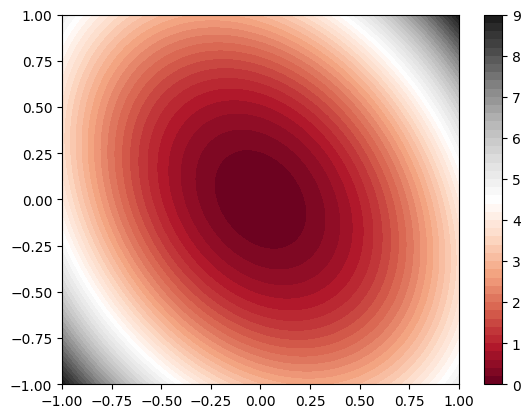

In [5]:
plot_ellipse()

Sampling from Boltzman distribution $\exp(-\beta V)$ is anallytically achievable by using multivariate normal distribution.

In [6]:
def sample_ellipse(
    N: int = 100, β: float = 1.0e01
) -> tuple[np.ndarray, np.ndarray]:
    # sample from a 2D Gaussian
    np.random.seed(0)
    A = np.array([[4, 1], [1, 3]])
    # Σ^-1 / 2 = A * β
    Σ = np.linalg.inv(A * β * 2.0)
    μ = np.array([0, 0])
    x = np.random.multivariate_normal(μ, Σ, N)
    return x[:, 0], x[:, 1]

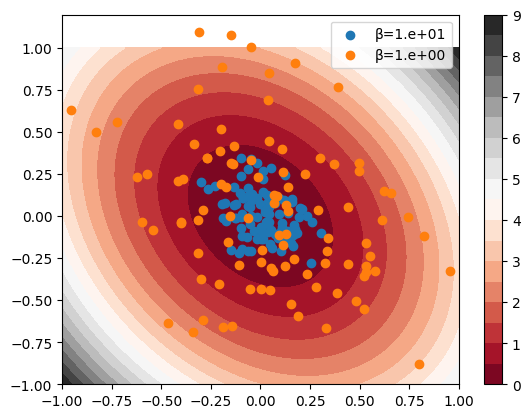

In [7]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = ellipse_pes(X.flatten(), Y.flatten()).reshape(X.shape)
plt.contourf(X, Y, Z, 20, cmap="RdGy", vmax=9, vmin=0)
plt.colorbar()
x, y = sample_ellipse(N=100, β=1.0e01)
plt.scatter(x, y, label="β=1.e+01")
x, y = sample_ellipse(N=100, β=1.0e00)
plt.scatter(x, y, label="β=1.e+00")
plt.legend()
plt.show()

One constructs following NNMPO

<img src='assets/pompon_2d.svg' width=600>

In [8]:
N = 20  # Number of basis per site
M = 1  # Bond dimension
nnmpo = pompon.model.NNMPO(
    input_size=2,
    hidden_size=2,
    basis_size=N,
    bond_dim=M,
    activation="silu",
)

You can change `activation`. See [`pompon.layers.activations`](../reference/layers.activations.qmd) for available activations.

Sample 256 points with temperature β=1.0

In [9]:
x, y = sample_ellipse(N=256, β=1.0e00)
x = np.stack([x, y], axis=1)
y = ellipse_pes(x[:, 0], x[:, 1]).reshape(-1, 1)
x_train, x_validate, y_train, y_validate = train_test_split(
    x, y, train_size=0.7
)
print(x_train.shape)
print(y_train.shape)

(179, 2)
(179, 1)


In [10]:
y_pred = nnmpo.forward(x_train)
print(y_pred.shape)

(179, 1)


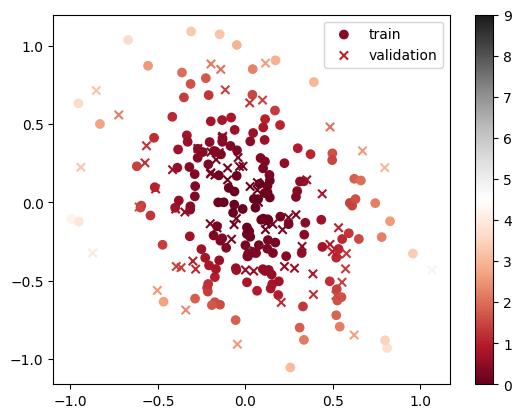

In [11]:
plt.scatter(
    x_train[:, 0],
    x_train[:, 1],
    c=y_train[:, 0],
    label="train",
    cmap="RdGy",
    vmax=9,
    vmin=0,
    marker="o",
)
plt.scatter(
    x_validate[:, 0],
    x_validate[:, 1],
    c=y_validate[:, 0],
    label="validation",
    cmap="RdGy",
    vmax=9,
    vmin=0,
    marker="x",
)
plt.colorbar()
plt.legend()
plt.show()

To grasp the optimization routine, one employs manual gradient descent (GD) rather than a trainer.

In [12]:
lr = 1.0e-02
lr_tt = 1.0e-04
train_losses = []
validation_losses = []
tt_rank_epochs = []
norms = []

In [13]:
def evaluate_loss(model, x, y, losses):
    y_pred = model.forward(x)
    loss = pompon.losses.mse(y, y_pred)
    losses.append(loss)
    return loss

In [14]:
for i_epoch in tqdm(range(20_000)):
    evaluate_loss(nnmpo, x_train, y_train, train_losses)
    evaluate_loss(nnmpo, x_validate, y_validate, validation_losses)
    params = nnmpo.grad(
        x_train, y_train, basis_grad=True, coordinator_grad=True
    )
    for param in params:
        param.data -= lr * param.grad
    if (i_epoch + 1) % 1_000 == 0:
        nnmpo.update_blocks_batch(x_train)
        for _ in tqdm(range(5_000)):
            params = nnmpo.grad(
                x_train, y_train, twodot_grad=True, to_right=True
            )
            B: TwodotCore = params[0]
            B.data -= lr_tt * B.grad
        nnmpo.tt.norm.data *= (norm := jnp.linalg.norm(B.data))
        B.data /= norm
        W0, W1 = B.svd(truncation=0.99, rank=2)
        nnmpo.tt.W0.data = W0.data
        nnmpo.tt.W1.data = W1.data
    norms.append(nnmpo.tt.norm.data)
    tt_rank_epochs.append(nnmpo.tt.ranks)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Explanation of the code:

- Lines 1~3:
  ```python
  for i_epoch in tqdm(range(20_000)):
     evaluate_loss(nnmpo, x_train, y_train, train_losses)
     evaluate_loss(nnmpo, x_validate, y_validate, validation_losses)
  ```
  Performs training for 20,000 epochs. Calculates Mean Squared Error (MSE) every epoch and logs it.

- Lines 4~6:
  ```python
     params = nnmpo.grad(x_train, y_train, basis_grad=True, coordinator_grad=True)
     for param in params:
        param.data -= lr * param.grad
  ```
  Retrieves gradients for parameters $w$, $b$, and $U$ using automatic differentiation and optimizes them using gradient descent.
  The $U$ is automatically retracted to the Stiefel manifold by calling `-` operator.

- Lines 7~8:
  ```python
     if (i_epoch +1) % 1_000 == 0:
        nnmpo.update_blocks_batch(x_train)
  ```
  Optimizes Tensor Train (TT) every 1000 epochs.
  Computes all TT basis for each batch.

- Lines 9~12:
  ```python
        for _ in tqdm(range(5_000)):
            params = nnmpo.grad(x_train, y_train, twodot_grad=True)
            B = params[0] # 
            B.data -= lr_tt * B.grad
  ```
  Twodot core $B$ is also optimized by using gradient descent.
  Here, gradients are calculated analytically.

- Lines 13~17:
  ```python
        nnmpo.tt.norm.data *= (norm := jnp.linalg.norm(B.data))
        B.data /= norm
        W0, W1 = B.svd(truncation=0.99, rank=2)
        nnmpo.tt.W0.data = W0.data
        nnmpo.tt.W1.data = W1.data
  ```
  After gradient descent optimization of Twodot core $B$,
  Twodot core $B$ is normalized and decomposed into two Onedot cores $W$ using Singular Value Decomposition (SVD).
  It adaptively truncates small singular values and corresponding singular vectors,
  keeping only the top 99% contribution.
  

**Why did we set `rank=2`?**

  The elliptic function has a 3-rank structure.
  $$
  4x^2 + 3y^2 + 2xy = 
  \begin{bmatrix}
  4x^2 & 2x & 1
  \end{bmatrix}
  \begin{bmatrix}
  1 \\
  y \\
  3y^2
  \end{bmatrix}
  $$
  However, if coordinator learns low-rank coordinates,
  $$
  [q_1, q_2] = [x, y] U
  $$
  where $U$ diagonalizes the Hessian matrix,
  $$
  A = 
  \begin{bmatrix}
  8 & 1 \\
  1 & 6
  \end{bmatrix}
  $$
  then, the elliptic function becomes
  $$
  4x^2 + 3y^2 + 2xy = \lambda_1 q_1^2 + \lambda_2 q_2^2
  $$
  where $\lambda_1$ and $\lambda_2$ are eigenvalues of $A$.
  Thus, we can rewrite the elliptic function as a 2-rank structure.
  $$
  \begin{bmatrix}
  \lambda_1 & \lambda_2 q_1^2 \\
  \end{bmatrix}
  \begin{bmatrix}
  q_2^2 \\
  1 
  \end{bmatrix}
  $$


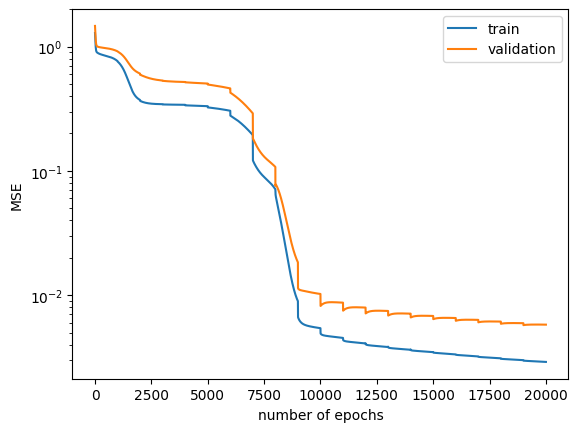

In [15]:
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.xlabel("number of epochs")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()

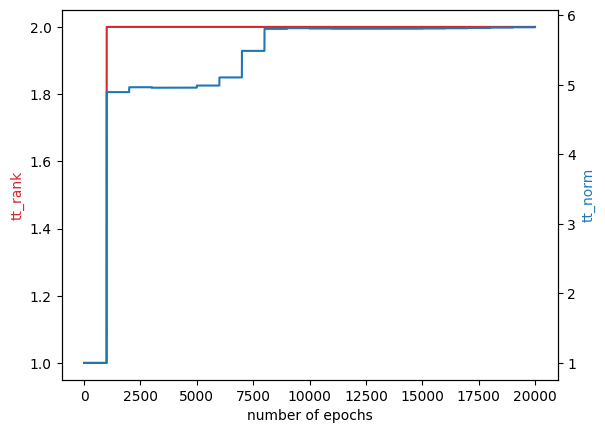

In [16]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("number of epochs")
ax1.set_ylabel("tt_rank", color=color)
ax1.plot(np.array(tt_rank_epochs), color=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("tt_norm", color=color)
ax2.plot(np.array(norms), color=color)

plt.show()

Visualize results

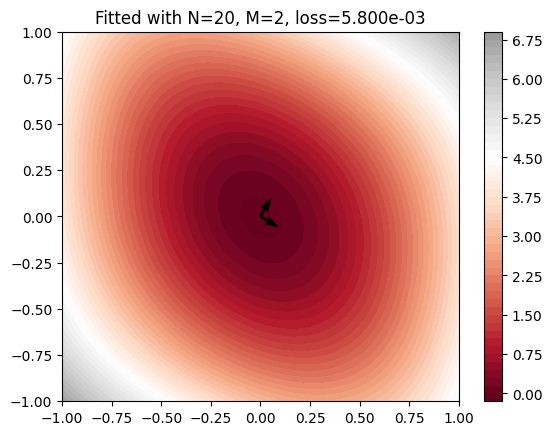

In [17]:
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x, y)
Z = nnmpo.forward(jnp.stack([X.flatten(), Y.flatten()], axis=1))[:, 0].reshape(
    X.shape
)
plt.title(
    f"Fitted with N={N}, "
    + f"M={max(tt_rank_epochs[-1])}, "
    + f"loss={validation_losses[-1]:.3e}"
)
plt.contourf(X, Y, Z, 50, cmap="RdGy", vmax=9, vmin=0)
plt.colorbar()
u = nnmpo.coordinator.U.data[0, :]
v = nnmpo.coordinator.U.data[1, :]
plt.quiver(0, 0, u[0], u[1])
plt.quiver(0, 0, v[0], v[1])
plt.show()